In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from populator import aggregate_data

exchanges = ['binance']
pairs = ['AE/BNB', 'ETH/BTC', 'BTC/USD']
aggregate_data('data', exchanges, pairs, '1m', '2000-01-01T00:00:00Z')

Loaded pair AE/BNB on binance (2018-02-07 11:59:00 to 2019-03-14 00:17:00)
Loaded pair ETH/BTC on binance (2017-07-14 04:00:00 to 2019-03-14 00:17:00)


,open_binance_AE_BNB,high_binance_AE_BNB,low_binance_AE_BNB,close_binance_AE_BNB,volume_binance_AE_BNB,open_binance_ETH_BTC,high_binance_ETH_BTC,low_binance_ETH_BTC,close_binance_ETH_BTC,volume_binance_ETH_BTC
timestamp,,,,,,,,,,
2017-07-14 04:00:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.043
2017-07-14 04:01:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.000
2017-07-14 04:02:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.306
2017-07-14 04:03:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.212
2017-07-14 04:04:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.165
2017-07-14 04:05:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.831
2017-07-14 04:06:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.498
2017-07-14 04:07:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,1.998
2017-07-14 04:08:00,NaN,NaN,NaN,NaN,NaN,0.080000,0.080000,0.080000,0.080000,0.000


In [ ]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

data = prep_data('data/data.p')
print(data['prices'].head())
print(data['volumes'].head())
# viz_data(data)
# data_min = reduce_data(prep_data('data/data-minute.p'), '1Min')
# data_5min = reduce_data(data_min, '5Min')
# data_15min = reduce_data(data_min, '15Min')
# viz_data(data_min)

In [ ]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [ ]:
def cross_correlate_(x, y):
    return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

def cross_correlate(df):
    '''Compute cross-correlation matrix for the given dataframe.'''
    ccs = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i == j:
                ccs.loc[i,j] = 0
                continue
            if np.isnan(ccs.loc[i,j]):
                ccs.loc[i,j] = cross_correlate_(df[i], df[j])
                ccs.loc[j,i] = -ccs.loc[i,j]
    return ccs

print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
print(cross_correlate(data_min['prices']))

In [ ]:
from strategy import HoldStrategy

analyze(run(HoldStrategy(), data))

In [ ]:
from strategy import MovingAverage, Gaussian
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt

class KalmanFilter(Strategy):
    '''Predicts fairs based on correlated movements between pairs. All inputs should be cointegrated.
    '''
    def __init__(self, correlation_window_size, movement_half_life):
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(movement_half_life)
        self.prev_prediction = None
        
    def step(self, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        
        if self.prev_prediction is None:
            self.prev_prediction = self.null_estimate(prices)
        
        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return self.null_estimate(prices)
        
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return self.null_estimate(prices)
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        diffs = df.diff().iloc[1:]
        diff = Gaussian(diffs.iloc[-1], diffs.var())
        # Could also calculate diff from the raw price movements but using smoothed movements for diff seems to
        # improve RoR
        
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_delta_means = corr.mul(deltas, axis=0).mul(stddevs, axis=1).div(stddevs, axis=0)
        predicted_delta_variances = df.cov().div(stddevs, axis=0).pow(2) / (corr * corr) # scale by 1/r^2
        predicted_deltas = Gaussian.join([Gaussian(predicted_delta_means.loc[i], predicted_delta_variances.loc[i]) for i in prices.index])
        
        new_prediction = Gaussian.sum([self.prev_prediction, diff]) & (predicted_deltas + df.mean())
        self.prev_prediction = new_prediction
        return new_prediction

analyze(run(KalmanFilter(correlation_window_size = 64, movement_half_life = 3), data_15min, fees=0.002))

In [ ]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt
from johansen.johansen import Johansen

def cointegrate(data):
    '''Returns eigenvectors for statistically-significant cointegration relations.
    TODO: return confidences, by using eigenvalues directly.'''
    eigenvectors, r = Johansen(data, model=2, significance_level=1).johansen()
    return np.array(eigenvectors)[r]

def plot_eigenvectors(evs):
    evs /= np.linalg.norm(evs, axis=1, keepdims=True)
    plot_matrix(pd.DataFrame(evs))

class Cointegrater(Strategy):
    def __init__(self, cointegration_window_size):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge'''
        self.cointegration_window = None
        self.cointegration_window_size = cointegration_window_size
        
    def step(self, prices, _volumes):
        if self.cointegration_window is None:
            self.cointegration_window = RingBuffer(self.cointegration_window_size, dtype=(np.float, len(prices.index)))
        
        self.cointegration_window.append(prices)
        
        if len(self.cointegration_window) < self.cointegration_window_size:
            return self.null_estimate(prices)
        
        df = pd.DataFrame(np.array(self.cointegration_window), columns = prices.index)
        
        relations = cointegrate(df)
        fairs = [] # 1 fair estimate per covariance relation
        for relation in relations:
            R = np.broadcast_to(relation, (prices.shape[0], prices.shape[0])).copy()
            R /= np.diag(R)[:None]
            np.fill_diagonal(R, 0)
            synth_cointegrations = pd.DataFrame(df.values.dot(R), columns = df.columns)
            fair_mean = prices + synth_cointegrations.iloc[-1] - synth_cointegrations.mean()
            fair_variance = synth_cointegrations.var()
            fairs.append(Gaussian(fair_mean, fair_variance))
        if len(fairs) > 0:
            return Gaussian.join(fairs)
        else:
            return self.null_estimate(prices)

plot_results(run(Cointegrater(cointegration_window_size = 64), tail_data(data, 1000)))

In [ ]:
plot_results(run(Cointegrater(cointegration_window_size = 16), data_15min))

In [ ]:
plot_results(run(KalmanFilter(correlation_window_size = 60, movement_half_life = 3), data_15min))

In [ ]:
from strategy import CombinedStrategy

plot_results(run(CombinedStrategy([
    KalmanFilter(correlation_window_size = 60, movement_half_life = 3),
    Cointegrater(cointegration_window_size = 16)
]), data_15min))

In [ ]:
plot_results(run(Cointegrater(cointegration_window_size = 512), data_5min))

In [ ]:
analyze(evaluate(KalmanFilter(correlation_window_size = 165, movement_half_life = 70), data_5min))

In [ ]:
plot_results(run(CombinedStrategy([
    KalmanFilter(correlation_window_size = 16, movement_half_life = 8),
    Cointegrater(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

Trying window_size: 215 and half_life: 79.87936771139888
  RoR: 0.17311617585440975
Trying window_size: 121 and half_life: 6.212537462602108
  RoR: 0.1899185447538888
Trying window_size: 107 and half_life: 79.90842125720259
  RoR: 0.15132028825885938
Trying window_size: 165 and half_life: 70.94288261340017
  RoR: 0.2019962879665104
Trying window_size: 167 and half_life: 29.848107296600205
  RoR: 0.17758433879462587
Trying window_size: 60 and half_life: 1.7540906707347852
  RoR: 0.12032534753826656
Trying window_size: 124 and half_life: 13.892728662930411
  RoR: 0.16342175012599314
Trying window_size: 78 and half_life: 35.29888565964528
  RoR: 0.15080339333004827
Trying window_size: 92 and half_life: 10.979957444445429
  RoR: 0.16910642505888426
Trying window_size: 111 and half_life: 45.94492009720074
  RoR: 0.16851420367769174
Trying window_size: 130 and half_life: 16.969962146951808
  RoR: 0.16136107089585075
Trying window_size: 87 and half_life: 15.715187085517591
  RoR: 0.1624563865

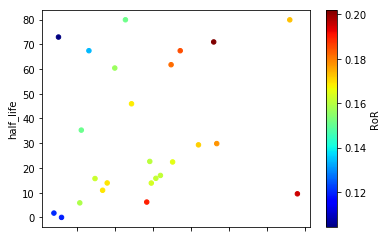

In [28]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 30
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 60) + 60
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = run(KalmanFilter(window_size, movement_half_life), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_5min, 1000), 25)